## **Area-average over complete surface**

The area-averaged WSS is defined as:

\begin{equation}
    \left \langle WSS_A \right \rangle (t)
    =
    \frac{1}{A}
    \int_{S}{}
        \left\| \vec{WSS} (\vec{x},t) \right\| 
        \mathrm{d}S   
\end{equation}

where $A$ is the area of the surface $S$. Note that $\left \langle WSS_A \right \rangle (t)$ will be a function of time. This metric is used to numerically verify the results with respect to mesh independence analysis. Physically, it is equivalent to an overall traction due to the tangential viscous stress on the surface. 

According to authors like Roach and Ferziger, in a Richardson extrapolation-like analysis, it is possible to use integral or derivatives of the priumitive variables to analyze mesh convergence. Ideally, one should analyze both primitive variables in specific locations and quadratures of these that are the variables that will be used in the study being carried-out. First, we will integrate the variables on the chosen surface and in the sequence, we must multiply the magWSS resultant field by the density $\rho = 1056 kg/m^3$, because the loaded 'wallShearComponent' in OpenFOAM is calculated per specific mass unity. 

<hr>

## **OSI and RRT**

In this part of this notebook we will created a sequence of commands to calculate the *oscillatory shear index* (OSI) of a WSS field in an aneurysm surface, from CFD results and using ParaView's Temporal Statistics filter. The function also computes time-averaged data of the WSS, necessary in the OSI definition, and also the *relative residence time (RRT)*.

The OSI is defined as:

\begin{equation}
    OSI(\vec{x})
    =
    \frac{1}{2}
    \left(
        1 
        -
        \frac{
            \left \| 
            \displaystyle\int_0^{T}
            {
                \overrightarrow{WSS} (\vec{x},t)
                \mathrm{d}t
            }
            \right \|
        }{
            \displaystyle\int_0^{T}
            {
                \left \| \vec{WSS} (\vec{x},t) \right \|
                \mathrm{d}t
            }
        }
    \right)
\end{equation}

it measures how the WSS direction changes in time. The RRT is defined as:

\begin{equation}
    RRT(\vec{x})
    =
    \frac{1}{
            \frac{1}{T}
                \left \| 
                    \displaystyle\int_0^{T}
                    {
                        \vec{WSS} (\vec{x},t)
                        \mathrm{d}t
                    }
                \right \|
      }
     =
     \frac{1}{(1 - 2OSI)\overline{WSS}}
\end{equation}


<hr>

## **Computing integrals over space (aneurysm surface) of time-averaged WSS**

The following code computes the integrals over the aneurysm surface of the time-averaged WSS, already calculated in a single surface by, for example, using the OSI function, above. Therefore, the code only clips the aneurysm neck in the same points as used above to compute the time-dependent WSS surface integrals. 

The procedure then will provide a representative value of WSS used for comparison with other publications. With the time-averaged defined as:

\begin{equation}
    \overline{WSS}(\vec{x})
    =
    \frac{1}{T}
    \int_0^{T}
    {
        \left \| \vec{WSS} (\vec{x},t) \right \|
        \mathrm{d}t
    }
\end{equation}

which is called "wallShearComponent_magnitude_average". This is, therefore, a single spatial field defined on the aneurysm surface. Two quantities are extracted from it: 

    - the aneurysm surface-averaged: 
\begin{equation}
    WSS_{av}
    =
    \frac{1}{A_a}
    \int_{S_a}{}
        \overline{WSS}(\vec{x})
    \mathrm{d}S_a   
\end{equation}

    - the maximum value of $\overline{WSS}(\vec{x})$:
\begin{equation}
    WSS_{max} 
    =
    \max_{\vec{x} \in S_a} \overline{WSS}(\vec{x})
\end{equation}

<hr>

## **Post-process aneurysm surface integrals over time**

The procedure below calculates the integral over the aneurysm surface $S_a$ of the WSS magnitude, which is a time-dependent integral:

\begin{equation}
    \left \langle WSS \right \rangle (t)
    =
    \frac{1}{A_a}
    \int_{S_a}{}
        \left \| \vec{WSS} \right \|
    \mathrm{d}S_a   
\end{equation}

which is a measure of the total traction due to the tangential component of viscous traction on the aneurysm surface $S_a$. 

The procedure loads an OpenFOAM case of the aneurysm simulation and another surface must be loaded where is stored the array to clip the aneurysm neck: this can be performed in VMTK on a surface where the time averaged field were computed (time-average of WSS magnitude, magnitude of time-averaged WSS vector and OSI). 

<hr>

## Normalized area of *low WSS*

The metric *low WSS area (LSA)* (Jou et al. 2008 - Jou2008a), defined as ratio between the area of the aneurysm wall exposed to a WSS below 10% of the mean parent arterial WSS, $WSS_{pa}$, (or another reference value) and the dome surface area, $A_a$. Being the surface under low WSS given by:

\begin{equation}
    S_{LSA} =
    \left \{
        \vec{x} \in S_a | \overline{WSS} (\vec{x}) < lowWSS
    \right \}
\end{equation}

where the $lowWSS$ is usually 10% of $WSS_{pa}$. Then, the $LSA$ is as follows:

\begin{equation}
    LSA = \frac{A(S_{LSA})}{A_a}
\end{equation}

This metric is usually calculated for the time-averaged WSS, $\overline{WSS}(\vec{x})$, however, it can also be calculated over time, for the instantaneous WSS field.

The mean parent artery WSS, $WSS_{pa}$, must be calculated on the anterior genu of the internal carotid siphon for lateral aneurysms on the ICA for example, but, in general, some studies compute the LSA averaged value on the aneurysm parent artery by averaging the WSS vector over a strip defined on the vessel wall. This reference is used because it is considered as a normal WSS level in the aneurysm region. This definition was also used originally by Jou et al. (2008).

In this notebook, we will calculate the LSA based on a generic *lowWSSValue*, which can be chosen by the user.


In [66]:
# %%writefile aneurysms.py

import paraview.simple as pv
import numpy as np

In [65]:
def area_averaged_wss(case):
    """ Function that calculates the area-averaged WSS
        for a surface where the wall shear stress field
        is defined. The function takes its input an 
        OpenFOAM case reader with the surface and fields.
        It automatically selects the wallShearComponent field
        and the surface wall. It returns an array with time
        in one column and the result in the other. 
    """
    # Update arrays to be used:
    # - wallShearComponent
    

    case.CellArrays  = ['wallShearComponent']

    # And select the surface where integration will be carried out
    case.MeshRegions = ['wall']

    # Get time-steps values
    timeSteps = np.array(case.TimestepValues)
    # Update time-step
    case.UpdatePipeline()

    # Integrate WSS on the wall
    computeWallArea = pv.IntegrateVariables()
    computeWallArea.Input = case
    computeWallArea.UpdatePipeline()
    
    # Get area of surface, in m2
    wallArea = computeWallArea.CellData.GetArray('Area').GetRange()[0]

    areaAveragedWSSList = []
    for timeStep in timeSteps:
        # Calculate WSS magnitude
        # Instantiate calculater filter
        calcMagWSS = pv.Calculator()
        calcMagWSS.Input = case
        calcMagWSS.ResultArrayName = 'magWSS'
        calcMagWSS.Function = '1056*mag(wallShearComponent)'
        calcMagWSS.AttributeType = 'Cell Data'
        calcMagWSS.UpdatePipeline(time=timeStep)

        # Integrate WSS on the wall
        integrateWSS = pv.IntegrateVariables()
        integrateWSS.Input = calcMagWSS
        integrateWSS.UpdatePipeline(time=timeStep)

        # Instantiate calculater filter
        areaAveragedWSS = pv.Calculator()
        areaAveragedWSS.Input = integrateWSS
        areaAveragedWSS.ResultArrayName = 'areaAveragedWSS'
        areaAveragedWSS.Function = 'magWSS/'+str(wallArea)
        areaAveragedWSS.AttributeType = 'Cell Data'
        areaAveragedWSS.UpdatePipeline(time=timeStep)
        areaAveragedWSSList.append([timeStep, 
                                    areaAveragedWSS.CellData.GetArray('areaAveragedWSS').GetRange()[0]])

    return np.asarray(areaAveragedWSSList)


def osi(ofCaseFile, 
        timeIndexRange, 
        outputFileName,
        timeStep=0.01,
        density=1056.0, # kg/m3
        wssFieldName='wallShearComponent', 
        patchName='wall'):
    """ 
        Function to calculate the oscillatory shear index and
        other time integrals variables of WSS over a time inter-
        val [Ti,Tf] indentified by time-step indices. The method
        (based o VTK), ignores the time-step size and 
        consider uniform time stepping (so, if the time-step is 
        large, the resulting fields may be very different if a va-
        riable time-step would be considered). The OSI field is 
        defined as:
        
            OSI = 0.5*( 1 - norm2(int WSS dt) / int norm2(WSS) dt)
            
        where "int" implies the integral over time between two
        instants t1 and t2 (usually for a cardiac cycle, therefore 
        [t1, t2] = [Ti, Tf]) and norm2 is the L2 norm of an Eucli-
        dean vector field; WSS is the wall shear stress defined on 
        the input surface. Since this function use OpenFOAM data, 
        please specify the density considered.
        
        Input args:
        - OpenFOAM case file (str): name of OpenFOAM .foam case;
        - wssFieldName (str, optional): string containing the name 
            of the wall shear stress field (default="wallShearComp-
            onent");
        - patchName (str, optional): patch name where to calculate 
            the OSI (default="wall");
        - timeIndexRange (list): list of initial and final time-
            steps indices limits of the integral [Ti, Tf];
        - outputFileName (str): file name for the output file with 
            osi field (must be a .vtp file).
        - blood density (float, optional): default 1056.0 kg/m3
    """
    case = pv.OpenFOAMReader(FileName=ofCaseFile)

    # First we define only the field that are going to be used: the WSS on the aneurysm wall
    case.CellArrays = [wssFieldName]
    case.MeshRegions = [patchName]
    case.Createcelltopointfiltereddata = 0

    # Multiplying WSS per density
    densityTimesWSS = pv.Calculator()
    densityTimesWSS.Input = case
    densityTimesWSS.AttributeType   = 'Cell Data'
    densityTimesWSS.ResultArrayName = "WSS"
    densityTimesWSS.Function = str(density)+"*"+wssFieldName
    densityTimesWSS.UpdatePipeline()

    # Calculating the magnitude of the wss vector
    calcMagWSS = pv.Calculator()
    calcMagWSS.Input = densityTimesWSS
    calcMagWSS.AttributeType   = 'Cell Data'
    calcMagWSS.ResultArrayName = densityTimesWSS.ResultArrayName+"_magnitude"

    ## Get WSS field name
    wss = densityTimesWSS.ResultArrayName
    calcMagWSS.Function = "mag("+wss+")"
    calcMagWSS.UpdatePipeline()

    # Extract desired time range
    timeInterval = pv.ExtractTimeSteps()
    timeInterval.Input = calcMagWSS
    timeInterval.SelectionMode = "Select Time Range"
    timeInterval.TimeStepRange = timeIndexRange #[99, 199] # range in index
    timeInterval.UpdatePipeline()

    # Period given by time-steps
    period = (timeInterval.TimeStepRange[1] - timeInterval.TimeStepRange[0])*timeStep

    # Now compute the temporal statistics
    # filter computes the average values of all fields
    calcAvgWSS = pv.TemporalStatistics()

    calcAvgWSS.Input = timeInterval
    calcAvgWSS.ComputeAverage = 1
    calcAvgWSS.ComputeMinimum = 0
    calcAvgWSS.ComputeMaximum = 0
    calcAvgWSS.ComputeStandardDeviation = 0
    calcAvgWSS.UpdatePipeline()

    # Calculates OSI
    calcOSI = pv.Calculator()
    calcOSI.Input = calcAvgWSS
    calcOSI.ResultArrayName = 'OSI'
    calcOSI.AttributeType = 'Cell Data'

    # Getting fields:
    # - Get the average of the vector WSS field
    avgVecWSS = calcAvgWSS.CellData.GetArray(wss+"_average").GetName()
    # - Get the average of the magnitude of the WSS field 
    avgMagWSS = calcAvgWSS.CellData.GetArray(calcMagWSS.ResultArrayName+"_average").GetName()

    calcOSI.Function = "0.5*( 1 - ( mag( "+avgVecWSS+" ) )/"+avgMagWSS+" )"
    calcOSI.UpdatePipeline()

    # Compute Relative Residance Time
    calcRRT = pv.Calculator()
    calcRRT.Input = calcOSI
    calcRRT.ResultArrayName = 'RRT'
    calcRRT.AttributeType   = 'Cell Data'
    calcRRT.Function        = str(period)+"/mag("+avgVecWSS+")"
    calcRRT.UpdatePipeline()

    # Final processing of surface: merge blocks
    # and get surface for triangulation
    mergeBlocks = pv.MergeBlocks()
    mergeBlocks.Input = calcRRT
    mergeBlocks.UpdatePipeline()

    extractSurface = pv.ExtractSurface()
    extractSurface.Input = mergeBlocks
    extractSurface.UpdatePipeline()

    triangulate = pv.Triangulate()
    triangulate.Input = extractSurface
    triangulate.UpdatePipeline()

    pv.SaveData(outputFileName,triangulate)

    
    
def wss_statistics(timeAveragedSurface, aneurysmNeckArrayName, neckIsoValue=0.5):
    """
        Computes surface-averaged and maximum value 
        of time-averaged WSS for an aneurysm surface.
        Input is a PolyData surface with the averaged
        fields and the aneurysm neck contour field. 
        Return list with aneurysm area, WSSav and 
        WSSmax.
    """
    clipAneurysmNeck = pv.Clip()
    clipAneurysmNeck.Input = timeAveragedSurface
    clipAneurysmNeck.ClipType = 'Scalar'
    clipAneurysmNeck.Scalars  = [aneurysmNeckArrayName]
    clipAneurysmNeck.Invert   = 1   # gets smaller portion
    clipAneurysmNeck.Value    = neckIsoValue  # based on the definition of field ContourScalars
    clipAneurysmNeck.UpdatePipeline()

    # Finaly we integrate over Sa 
    integrateOverAneurysm = pv.IntegrateVariables()
    integrateOverAneurysm.Input = clipAneurysmNeck
    integrateOverAneurysm.UpdatePipeline()

    aneurysmArea = integrateOverAneurysm.CellData.GetArray("Area").GetRange()[0] # aneurysm area

    WSSav  = integrateOverAneurysm.CellData.GetArray("WSS_magnitude_average").GetRange()[0]/aneurysmArea # averaged
    WSSmax = clipAneurysmNeck.CellData.GetArray("WSS_magnitude_average").GetRange()[1] # maximum value
    WSSmin = clipAneurysmNeck.CellData.GetArray("WSS_magnitude_average").GetRange()[0] # minimum value
    
    return [aneurysmArea, WSSav, WSSmax, WSSmin]



def area_averaged_wss_aneurysm(ofCaseFile,
                               aneurysmClipSurface,
                               aneurysmNeckArrayName,
                               clipAneurysmNeck=0.5,
                               density=1056.0,
                               wssFieldName='wallShearComponent', 
                               patchName='wall'):
    """
        Function to compute surface integrals of 
        WSS over an aneurysm surface. It takes the 
        OpenFOAM case file and an extra surface where 
        it is stored a field with the aneurysm neck 
        line loaded as a ParaView PolyData surface.
        To my knowledge, it is important that the sur-
        face with thye neck line array be the same as 
        the wall surface of the OpenFOAM case, i.e.
        they are the same mesh.
    """

    # Clip original aneurysm surface in the neck line
    clipAneurysmNeck = pv.Clip()
    clipAneurysmNeck.Input    = aneurysmClipSurface
    clipAneurysmNeck.ClipType = 'Scalar'
    clipAneurysmNeck.Scalars  = ['POINTS', aneurysmNeckArrayName]
    clipAneurysmNeck.Invert   = 1
    clipAneurysmNeck.Value    = clipAneurysmNeck  # based on the definition of field ContourScalars
    clipAneurysmNeck.UpdatePipeline()
    
    integrateWSS = pv.IntegrateVariables()
    integrateWSS.Input = clipAneurysmNeck
    integrateWSS.UpdatePipeline()

    # Get area of surface, in m2
    aneurysmArea = integrateWSS.CellData.GetArray("Area").GetRange()[0]
    
    # Read OpenFOAM data and process the WSS
    # to get its magnitude
    ofData = pv.OpenFOAMReader(FileName=ofCaseFile)

    # Update arrays to be used:
    ofData.CellArrays   = [wssFieldName]
    ofData.MeshRegions  = [patchName]
    ofData.SkipZeroTime = 1

    # Get time-steps values
    timeSteps = np.array(ofData.TimestepValues)

    # Update time-step
    ofData.UpdatePipeline()

    # Triangulate data to coincide with
    triangulate = pv.Triangulate()
    triangulate.Input = ofData
    triangulate.UpdatePipeline()

    # Compute magnitude of WSS in each cell of the aneurysm surface
    magWSS = pv.Calculator()
    magWSS.Input    = triangulate
    magWSS.Function = str(density)+'*mag('+triangulate.CellData.GetArray(wssFieldName).Name+')'
    magWSS.AttributeType   = 'Cell Data'
    magWSS.ResultArrayName = 'magWSS'
    magWSS.UpdatePipeline()

    # Resample OpenFOAM data to clipped aneeurysm surface
    resampleDataset = pv.ResampleWithDataset()
    resampleDataset.Input  = magWSS
    resampleDataset.Source = clipAneurysmNeck
    resampleDataset.PassCellArrays  = 1
    resampleDataset.PassPointArrays = 1
    resampleDataset.UpdatePipeline()

    # Since all fields in ResampleWithDataSet filter 
    # are interpolated to points, therefore
    # apply point data to cell data fielte
    pointToCellData = pv.PointDatatoCellData()
    pointToCellData.Input = resampleDataset
    pointToCellData.UpdatePipeline()

    areaAveragedWSSList = []

    # # Iterate over time-steps to compute time dependent variables
    # # only on the aneurysm surface: mag of WSS over time 
    for timeStep in timeSteps[-100:-1]: # get last cycle only
        # Integrate WSS on the wall
        integrateWSS = pv.IntegrateVariables()
        integrateWSS.Input = pointToCellData
        integrateWSS.UpdatePipeline(time=timeStep)

        # Instantiate calculater filter
        areaAveragedWSS = pv.Calculator()
        areaAveragedWSS.Input = integrateWSS
        areaAveragedWSS.Function = integrateWSS.CellData.GetArray('magWSS').Name+'/'+str(aneurysmArea)        
        areaAveragedWSS.ResultArrayName = 'areaAveragedWSS'
        areaAveragedWSS.AttributeType = 'Cell Data'
        areaAveragedWSS.UpdatePipeline(time=timeStep)

        areaAveragedWSSList.append([timeStep, 
                                    areaAveragedWSS.CellData.GetArray('areaAveragedWSS').GetRange()[0]])

    return np.asarray(areaAveragedWSSList)



def lsa_wss_av(timeAveragedSurface, 
               aneurysmNeckArrayName,
               lowWSSValue, 
               clipAneurysmNeck=0.5):
    """ 
    Calculates the LSA (low WSS area ratio) for aneurysms
    simulations performed in OpenFOAM. Thi input is a sur-
    face with the time-averaged WSS over the surface and 
    an array defined on it indicating the aneurysm neck.
    The function then calculates the aneurysm surface area
    and the area where the WSS is lower than a reference 
    value provided by the user.
    """
    
    # Clip aneurysm surface
    clipAneurysmNeck = pv.Clip()
    clipAneurysmNeck.Input    = timeAveragedSurface
    clipAneurysmNeck.ClipType = 'Scalar'
    clipAneurysmNeck.Scalars  = ['POINTS', aneurysmNeckArrayName]
    clipAneurysmNeck.Invert   = 1             # gets smaller portion
    clipAneurysmNeck.Value    = neckIsoValue  # based on the definition of field ContourScalars
    clipAneurysmNeck.UpdatePipeline()
    
    # Integrate to get aneurysm surface area
    integrateOverAneurysm = pv.IntegrateVariables()
    integrateOverAneurysm.Input = clipAneurysmNeck
    integrateOverAneurysm.UpdatePipeline()
        
    aneurysmArea = integrateOverAneurysm.CellData.GetArray('Area').GetRange()[0] # m2

    # Clip the aneurysm surface in the lowWSSValue
    # ang gets portion smaller than it
    clipLSA = pv.Clip()
    clipLSA.Input = clipAneurysmNeck
    clipLSA.ClipType = 'Scalar'
    clipLSA.Scalars  = ['CELLS', 'WSS_magnitude_average']
    clipLSA.Invert   = 1   # gets portion smaller than the value
    clipLSA.Value    = lowWSSValue
    clipLSA.UpdatePipeline()

    # Integrate to get area of lowWSSValue
    integrateOverLSA = pv.IntegrateVariables()
    integrateOverLSA.Input = clipLSA
    integrateOverLSA.UpdatePipeline()
    
    area = integrateOverLSA.CellData.GetArray('Area')
    if area == None:
        lsaArea = 0.0
    else:
        lsaArea = integrateOverLSA.CellData.GetArray('Area').GetRange()[0]
    
    return lsaArea/aneurysmArea



def lsa_instant(ofDataFile, 
               aneurysmClipSurface,
               aneurysmNeckArrayName,
               lowWSSValue, 
               clipAneurysmNeck=0.5,
               density=1056.0,
               wssFieldName='wallShearComponent', 
               patchName='wall'):
    
    """ 
    Calculates the LSA (low WSS area ratio) for aneurysms
    simulations performed in OpenFOAM. The input is a sur-
    face with the time-averaged WSS over the surface an
    OpenFOAM case with the WSS field and a surface which
    contains the array with the aneurysm neck iso line.
    The function then calculates the aneurysm surface area
    and the area where the WSS is lower than a reference 
    value provided by the user, for each instant in the 
    cycles simulated, returning a list with the LSA values
    over time, for the last cycle.
    """
    
    # Clip original aneurysm surface in the neck line
    clipAneurysmNeck = pv.Clip()
    clipAneurysmNeck.Input = aneurysmClipSurface
    clipAneurysmNeck.ClipType = 'Scalar'
    clipAneurysmNeck.Scalars  = ['POINTS', aneurysmNeckArrayName]
    clipAneurysmNeck.Invert   = 1                   
    clipAneurysmNeck.Value    = clipAneurysmNeck    # based on the definition of field ContourScalars
    clipAneurysmNeck.UpdatePipeline()
    
    integrateWSS = pv.IntegrateVariables()
    integrateWSS.Input = clipAneurysmNeck
    integrateWSS.UpdatePipeline()

    # Get area of surface, in m2
    aneurysmArea = integrateWSS.CellData.GetArray("Area").GetRange()[0]

    # Read OpenFOAM data
    ofData = pv.OpenFOAMReader(FileName=ofDataFile)
    ofData.CellArrays   = [wssFieldName]            # Update arrays
    ofData.MeshRegions  = [patchName]
    ofData.SkipZeroTime = 1
    ofData.UpdatePipeline()                 
    
    # Get time-steps
    timeSteps = np.array(ofData.TimestepValues)
        
    # Triangulate data to coincide with time averaged surface
    # Error prone, the triangulation must be the same
    triangulate = pv.Triangulate()
    triangulate.Input = ofData
    triangulate.UpdatePipeline()

    # Compute magnitude of WSS in each cell of the aneurysm surface
    magWSS = pv.Calculator()
    magWSS.Input    = triangulate
    magWSS.Function = str(density)+'*mag('+triangulate.CellData.GetArray(wssFieldName).Name+')'
    magWSS.ResultArrayName = 'magWSS'
    magWSS.AttributeType   = 'Cell Data'
    magWSS.UpdatePipeline()

    # Resample OpenFOAM data to clipped aneeurysm surface
    resampleDataset = pv.ResampleWithDataset()
    resampleDataset.Input  = magWSS
    resampleDataset.Source = clipAneurysmNeck
    resampleDataset.PassCellArrays  = 1
    resampleDataset.PassPointArrays = 1
    resampleDataset.UpdatePipeline()

    # Clip the aneurysm surface in the lowWSSValue
    # ang gets portion smaller than it
    clipLSA = pv.Clip()
    clipLSA.Input    = resampleDataset
    clipLSA.Value    = lowWSSValue
    clipLSA.ClipType = 'Scalar'
    clipLSA.Scalars  = ['POINTS', 'magWSS']
    clipLSA.Invert   = 1   # gets portion smaller than the value
    clipLSA.UpdatePipeline()

    LSAt = []
    for instant in timeSteps[-100:-1]:                 # get always last cycle
        
        # Integrate to get area of lowWSSValue
        integrateOverLSA = pv.IntegrateVariables()
        integrateOverLSA.Input = clipLSA
        integrateOverLSA.UpdatePipeline(time=instant)

        area = integrateOverLSA.CellData.GetArray('Area')
        if area == None:
            lsaArea = 0.0
        else:
            lsaArea = integrateOverLSA.CellData.GetArray('Area').GetRange()[0]

        LSAt.append(lsaArea/aneurysmArea)
    
    return LSAt

Overwriting aneurysms.py


In [2]:
def aneurysm_area(timeAveragedSurface, 
                  aneurysmNeckArrayName,
                  neckIsoValue=0.5):
    """ Docstring """
    
    clipAneurysmNeck = pv.Clip()
    clipAneurysmNeck.Input = timeAveragedSurface
    clipAneurysmNeck.ClipType = 'Scalar'
    clipAneurysmNeck.Scalars  = ['POINTS', aneurysmNeckArrayName]
    clipAneurysmNeck.Invert   = 1   # gets portion smaller than neckIsoValue
    clipAneurysmNeck.Value    = neckIsoValue  # based on the definition of field ContourScalars
    clipAneurysmNeck.UpdatePipeline()

    # Finaly we integrate over Sa 
    integrateOverAneurysm = pv.IntegrateVariables()
    integrateOverAneurysm.Input = clipAneurysmNeck
    integrateOverAneurysm.UpdatePipeline()

    return integrateOverAneurysm.CellData.GetArray("Area").GetRange()[0] # aneurysm area    
    

In [6]:
# This calculation depends on the WSS defined only on the 
# parent artery surface. I thimk the easiest way to com-
# pute that is by drawing the artery contour in the same 
# way as the aneurysm neck is beuild. So, I will assume
# in this function that the surface is already cut to in-
# clude only the parent artery portion and that includes 

def wss_parent_vessel(parentVesselSurface,parentArteryArrayName,parentArteryIsoValue=0.5):
    """
    Calculates the surface averaged WSS value
    over the parent artery surface.
    """
    
    clipParentArtery = pv.Clip()
    clipParentArtery.Input    = parentVesselSurface
    clipParentArtery.ClipType = 'Scalar'
    clipParentArtery.Scalars  = ['POINTS', parentArteryArrayName]
    clipParentArtery.Invert   = 1                     # gets smaller portion
    clipParentArtery.Value    = parentArteryIsoValue  # based on the definition of field ContourScalars
    clipParentArtery.UpdatePipeline()

    # Finaly we integrate over Sa 
    integrateOverArtery = pv.IntegrateVariables()
    integrateOverArtery.Input = clipParentArtery
    integrateOverArtery.UpdatePipeline()

    parentArteryArea = integrateOverArtery.CellData.GetArray("Area").GetRange()[0] # aneurysm area

    return integrateOverArtery.CellData.GetArray("WSS_magnitude_average").GetRange()[0]/parentArteryArea

In [37]:
def prettyDict(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            prettyDict(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value) + '\n')

<hr>

# Test cells

In [41]:
import os, glob
import matplotlib.pyplot as plt

# import seaborn as sb
# plt.style.use('classic')

import json

In [ ]:
# foamFile = "/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/unruptured/fluidFlow/CarreauYasuda/case11/mesh1500k/mesh1500k.foam"
# surfaceFile = "/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/timeAveragedData/case11_timeAveragedWSSandOSI_CarreauYasuda.vtp"

In [ ]:
osi(foamFile, [99,199], surfaceFile)

From the time averaged files created above, area-averaging them to get WSS statistics

In [9]:
# Definitions
writeDir = "/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/timeAveragedData/processedData/"
rootPath = "/home/iagolessa/foam/iagolessa-4.0/run/aneurysms/"
models   = ["Newtonian", "Casson", "CarreauYasuda"]

rupturedCases   = ["case1", "case2", "case4", "case19"]
unrupturedCases = ["case11", "case13", "case17"]

states = ["ruptured", "unruptured"]

In [10]:
aneurysmNeckArrayName = "AneurysmNeckContour"
patentArteryArrayName = 'ParentArteryContour'
neckIsoValue = 0.5
peakSystoleInstant = 1.1

In [44]:
aneurysmsCases = ["case1", "case2", "case4ruptured", "case19", "case4unruptured", "case11", "case13", "case17"]
nCases = len(aneurysmsCases)

In [11]:
fileList = glob.glob("/home/iagolessa/Documents/unesp/doctorate/data/aneurysms/results/timeAveragedData/*.vtp")

In [13]:
wssStats = {key: {} for key in aneurysmsCases}
lsaStats = {key: {} for key in aneurysmsCases}

wssStats, lsaCases

{'case1': {},
 'case2': {},
 'case4ruptured': {},
 'case19': {},
 'case4unruptured': {},
 'case11': {},
 'case13': {},
 'case17': {}}

In [ ]:
# Calculate statistics for all files above

for surfaceFile in fileList:
    # Get file case identifier
    identifier = os.path.basename(surfaceFile).strip(".vtp").split("_")
    case  = identifier[0]
    model = identifier[2]

    # Check aneurysm state base on case
    if case in rupturedCases:
        aneurysmState = states[0]

        if case == "case4": 
            meshLevel = "mesh2000k"
        else:
            meshLevel = "mesh1500k"
            
    elif case in unrupturedCases:
        aneurysmState = states[1]
        
        if case == "case17": 
            meshLevel = "mesh1100k"
        else:
            meshLevel = "mesh1500k"
        
        
    # Build foam file path
    foamFile = rootPath+aneurysmState+"/fluidFlow/"+model+'/'+case+'/'+meshLevel+'/'+meshLevel+'.foam'
    print("Processing:", foamFile)

    # Load surface
    timeAveragedSurface = pv.XMLPolyDataReader(FileName=surfaceFile)
    
    # Compute array statistics
    # Check if reaches case4 (two aneurysms)
    if case == "case4":
        for state in states:
            # Compute statistics in each aneurysm
            timeAveragedSurface = pv.XMLPolyDataReader(FileName=surfaceFile)
            
            try:
                stat = wss_statistics(timeAveragedSurface, 
                                      state+aneurysmNeckArrayName)
                
                wssTime = area_averaged_wss_aneurysm(foamFile, 
                                                     timeAveragedSurface, 
                                                     state+aneurysmNeckArrayName)
                
                wssStats[case+state][model] = {"Area"  : stat[0],
                                               "WSSav" : stat[1],
                                               "WSSmax": stat[2],
                                               "WSSt"  : wssTime[:,1]}            
            except AttributeError:
                print("Attribute Error for case", surfaceFile)
            except:
                print("Error for case", surfaceFile)  
    else:        
        try:
            stat = wss_statistics(timeAveragedSurface, 
                                  aneurysmNeckArrayName)
                
            wssTime = area_averaged_wss_aneurysm(foamFile, 
                                                 timeAveragedSurface, 
                                                 aneurysmNeckArrayName)
            
            wssStats[case][model] = {"Area"  : stat[0],
                                     "WSSav" : stat[1],
                                     "WSSmax": stat[2],
                                     "WSSt"  : wssTime[:,1]}  
            
        except AttributeError:
            print("Attribute Error for case", surfaceFile)
        except:
            print("Error for case", surfaceFile) 

In [35]:
for surfaceFile in fileList:
    
    # Get file case identifier
    identifier = os.path.basename(surfaceFile).strip(".vtp").split("_")
    case  = identifier[0]
    model = identifier[2]
    print("Processing: ", case+' '+model)
    
    
    # Check aneurysm state base on case
    if case in rupturedCases:
        aneurysmState = states[0]

        if case == "case4": 
            meshLevel = "mesh2000k"
        else:
            meshLevel = "mesh1500k"
            
    elif case in unrupturedCases:
        aneurysmState = states[1]
        
        if case == "case17": 
            meshLevel = "mesh1100k"
        else:
            meshLevel = "mesh1500k"
        
        
    # Build foam file path
    foamFile = rootPath + aneurysmState + "/fluidFlow/"+model+'/'+case+'/'+meshLevel+'/'+meshLevel+'.foam'
    print("Loading OF case:", foamFile)
    
    # Compute array statistics
    # Check if reaches case4 (two aneurysms)
    if case == "case4":
        for state in states:
            print('Processing:', state)
            
            # Load surface
            timeAveragedSurface = pv.XMLPolyDataReader(FileName=surfaceFile)
            
            lowWSS = 0.10*wss_parent_vessel(timeAveragedSurface,
                                            patentArteryArrayName)
            
            try:
                
                LSAav = lsa_wss_av(timeAveragedSurface,
                                   state+aneurysmNeckArrayName,
                                   lowWSSValue=lowWSS)


                LSAOverTime = lsa_instant(foamFile,
                                          timeAveragedSurface,
                                          state+aneurysmNeckArrayName,
                                          lowWSSValue=lowWSS)

                lsaCases[case+state][model] = {"lowWSS": lowWSS,
                                               "LSAav" : LSAav,
                                               "LSAt"  : LSAOverTime}

                
            except AttributeError:
                print("Attribute Error for case", surfaceFile)
            except:
                print("Error for case", surfaceFile)  
                
    else:   
        timeAveragedSurface = pv.XMLPolyDataReader(FileName=surfaceFile)
        
        lowWSS = 0.10*wss_parent_vessel(timeAveragedSurface,
                                        patentArteryArrayName)     
        
        try:                
            LSAav = lsa_wss_av(timeAveragedSurface,
                               aneurysmNeckArrayName,
                               lowWSSValue=lowWSS)

            LSAOverTime = lsa_instant(foamFile,
                                      timeAveragedSurface,
                                      aneurysmNeckArrayName,
                                      lowWSSValue=lowWSS)

            lsaCases[case][model] = {"lowWSS": lowWSS, 
                                     "LSAav" : LSAav,
                                     "LSAt"  : LSAOverTime}
            
            
        except AttributeError:
            print("Attribute Error for case", surfaceFile)
        except:
            print("Error for case", surfaceFile) 

Processing:  case4 Newtonian
Loading OF case: /home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/Newtonian/case4/mesh2000k/mesh2000k.foam
Processing: ruptured
Processing: unruptured
Processing:  case11 Casson
Loading OF case: /home/iagolessa/foam/iagolessa-4.0/run/aneurysms/unruptured/fluidFlow/Casson/case11/mesh1500k/mesh1500k.foam
Processing:  case13 Newtonian
Loading OF case: /home/iagolessa/foam/iagolessa-4.0/run/aneurysms/unruptured/fluidFlow/Newtonian/case13/mesh1500k/mesh1500k.foam
Processing:  case4 CarreauYasuda
Loading OF case: /home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFlow/CarreauYasuda/case4/mesh2000k/mesh2000k.foam
Processing: ruptured
Processing: unruptured
Processing:  case11 CarreauYasuda
Loading OF case: /home/iagolessa/foam/iagolessa-4.0/run/aneurysms/unruptured/fluidFlow/CarreauYasuda/case11/mesh1500k/mesh1500k.foam
Processing:  case2 CarreauYasuda
Loading OF case: /home/iagolessa/foam/iagolessa-4.0/run/aneurysms/ruptured/fluidFl

In [38]:
prettyDict(lsaCases)

case1
	Newtonian
		lowWSS
			0.8500538801669972

		LSAav
			0.021597316895016604

		LSAt
			[0.20888988355113747, 0.1846373634663152, 0.16096249011871397, 0.14199065433347377, 0.11948219497941945, 0.08927761062852388, 0.054377696144068906, 0.031390927867059305, 0.02927358801728559, 0.020586568095359283, 0.009657414492701756, 0.012227375310527836, 0.00774446286101075, 0.010319713414124972, 0.013657194414295073, 0.014189989785549638, 0.03481358386601225, 0.023273917525822276, 0.025034278346183967, 0.021383522632120514, 0.02005679437681435, 0.015021929495556025, 0.024497838989903594, 0.025568723579715052, 0.028509364930354733, 0.022088320783751392, 0.02389120296460032, 0.03760672600883322, 0.04541457935662819, 0.044178904602931654, 0.04517080378756766, 0.04928268134788268, 0.05079439872660595, 0.05242643670470726, 0.04853149751289122, 0.04665769542098552, 0.04540860141167374, 0.04548653463196882, 0.04772684393864316, 0.04623557021361026, 0.04624934032780509, 0.047646884841620475, 0.046636

In [ ]:
# Tranforming array to list
statisticsBck = wssStats
for key in ["case13"]:
    for model in ["Newtonian"]:
        statisticsBck[key][model]["WSSt"] = wssStats[key][model]["WSSt"].tolist()

for case in wssStats.keys():
    with open(writeDir+'statisticsWSS_'+case+'.json', 'w') as fp:
        json.dump(wssStats[case], 
                  fp, 
                  sort_keys=True, 
                  indent=4)

In [ ]:
# Load already calculated data
for case in wssStats.keys():
    with open(writeDir+'statisticsWSS_'+case+'.json', 'r') as fp:
        wssStats[case] = json.load(fp)

prettyDict(wssStats)

In [42]:
for case in lsaCases.keys():
    with open(writeDir+'LSA_'+case+'.json', 'w') as fp:
        json.dump(lsaCases[case], 
                  fp, 
                  sort_keys=True, 
                  indent=4)

### Plotting the $LSA_{av}$ computed for the time-averaged WSS, $\overline{WSS}(\vec{x})$

In [62]:
error = {key: {} for key in lsaCases.keys()}

xlabelsLSAavg  = []

for key in error.keys():
    CassonVal = lsaCases[key]['Casson']['LSAav']
    NewtRef   = lsaCases[key]['Newtonian']['LSAav']
    CYValue   = lsaCases[key]['CarreauYasuda']['LSAav']
    
    if NewtRef < 0.001:
        error[key]['normErrAvCasson'] = 0.0  
        error[key]['normErrAvCY']     = 0.0
    else:
        error[key]['normErrAvCasson'] = round(100.0*( CassonVal - NewtRef )/NewtRef, 2)    
        error[key]['normErrAvCY']     = round(100.0*( CYValue   - NewtRef )/NewtRef, 2)
    
    xlabelsLSAavg.append(key+"\n Casson_Err= "+str(error[key]['normErrAvCasson'])+'%\n CY_Err= '+str(error[key]['normErrAvCY'])+'%') 

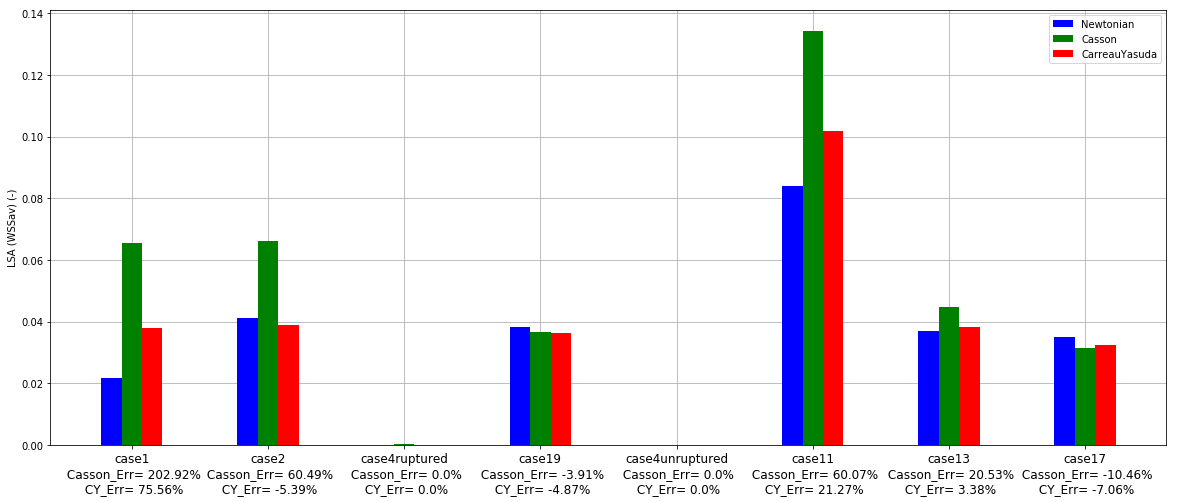

In [63]:
bwidth = 0.15
X = np.arange(nCases)

fig = plt.figure(figsize=(20,8))
ax1 = plt.axes()

ax1.bar(X + 0.00, [lsaCases[case][models[0]]["LSAav"] for case in lsaCases.keys()], color='b', width=bwidth, label=models[0])
ax1.bar(X + 0.15, [lsaCases[case][models[1]]["LSAav"] for case in lsaCases.keys()], color='g', width=bwidth, label=models[1])
ax1.bar(X + 0.30, [lsaCases[case][models[2]]["LSAav"] for case in lsaCases.keys()], color='r', width=bwidth, label=models[2])

ax1.set_ylabel('LSA (WSSav) (-)')
ax1.legend()
ax1.grid()
ax1.set_axisbelow(True)

plt.xticks(X+0.15, xlabelsLSAavg, fontsize='large')

plt.show()
fig.savefig(writeDir+'LSAav_perModel.png', bbox_inches='tight')

In [50]:
arrangement = [(0, 0, "case1"), 
               (0, 1, "case2"),
               (0, 2, "case4ruptured"),
               (0, 3, "case19"),
               (1, 0, "case4unruptured"),
               (1, 1, "case11"),
               (1, 2, "case13"),
               (1, 3, "case17"),]

### Plotting the $LSA_{t}$ over time for $WSS(\vec{x},t)$, per case comparing each model

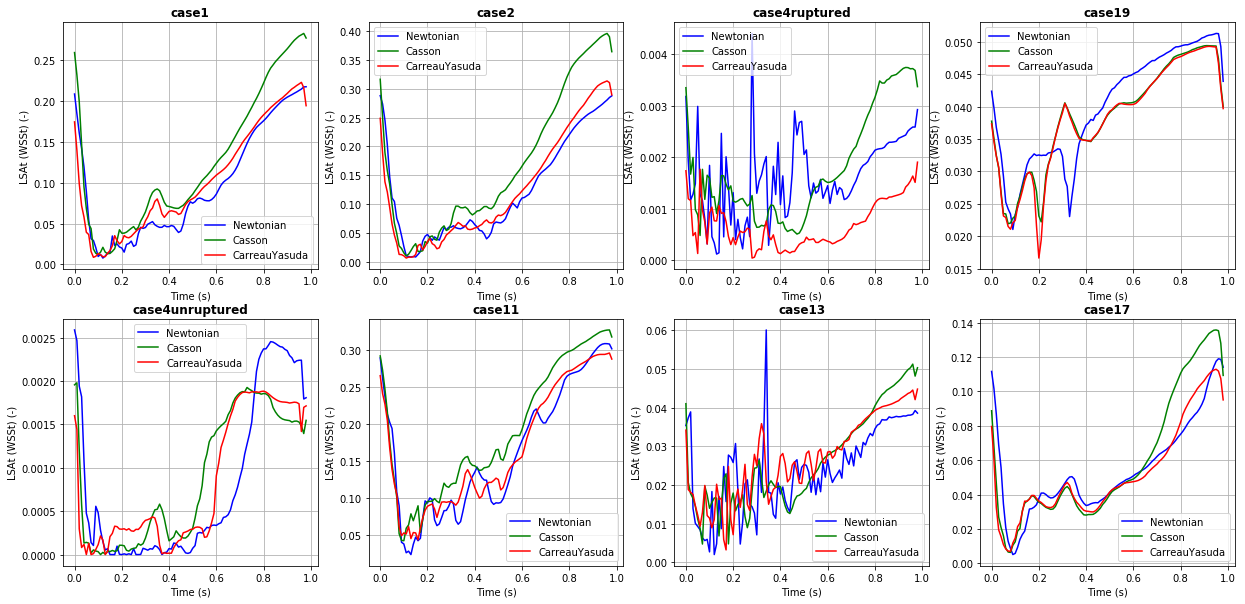

In [51]:
#%matplotlib widget
time = np.arange(0,0.99,0.01)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(21,10))

for row,column,case in arrangement:
    axes[row,column].plot(time, lsaCases[case][models[0]]["LSAt"][:], '-b', label=models[0])
    axes[row,column].plot(time, lsaCases[case][models[1]]["LSAt"][:], '-g', label=models[1])
    axes[row,column].plot(time, lsaCases[case][models[2]]["LSAt"][:], '-r', label=models[2])

    axes[row,column].set_title(case, fontweight="bold")
    axes[row,column].set_xlabel('Time (s)')
    axes[row,column].set_ylabel('LSAt (WSSt) (-)')
    axes[row,column].legend()
    axes[row,column].grid()
    
plt.show()
fig.savefig(writeDir+'LSAOverTime_perCase.png', bbox_inches='tight')

In [53]:
# Integrating over time the LSAt = LSAt(t)
from scipy import integrate

In [56]:
for case in lsaCases.keys():
    for model in lsaCases[case].keys():
        x = time
        y = np.array(lsaCases[case][model]['LSAt'])
        
        integral = integrate.simps(y, x)
        
        lsaCases[case][model]['intLSAt'] = integral

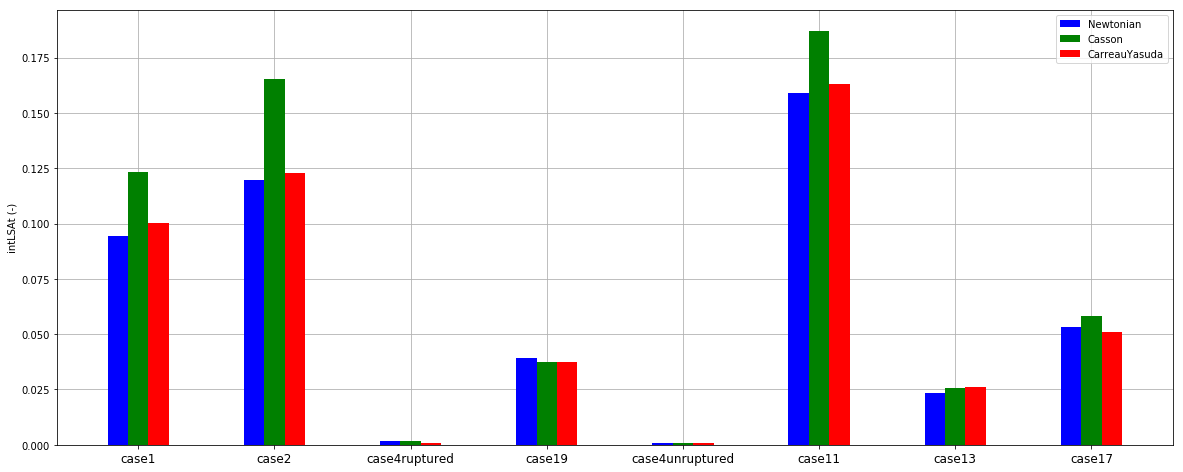

In [67]:
bwidth = 0.15

fig = plt.figure(figsize=(20,8))
ax1 = plt.axes()

ax1.bar(X + 0.00, [lsaCases[case][models[0]]["intLSAt"] for case in lsaCases.keys()], color='b', width=bwidth, label=models[0])
ax1.bar(X + 0.15, [lsaCases[case][models[1]]["intLSAt"] for case in lsaCases.keys()], color='g', width=bwidth, label=models[1])
ax1.bar(X + 0.30, [lsaCases[case][models[2]]["intLSAt"] for case in lsaCases.keys()], color='r', width=bwidth, label=models[2])

ax1.set_ylabel('intLSAt (-)')
ax1.legend()
ax1.grid()
ax1.set_axisbelow(True)

plt.xticks(X+0.15, lsaCases.keys(), fontsize='large')

plt.show()
fig.savefig(writeDir+'intLSAt.png', bbox_inches='tight')

### Plotting area-averaged WSS over time, $\left \langle WSS(\vec{x}) \right \rangle (t)$, per case comparing each model

In [ ]:
#%matplotlib widget
time = np.arange(0,0.99,0.01)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(21,10))

for row,column,case in arrangement:
    axes[row,column].plot(time, wssStats[case][models[0]]["WSSt"][:], '-b', label=models[0])
    axes[row,column].plot(time, wssStats[case][models[1]]["WSSt"][:], '-g', label=models[1])
    axes[row,column].plot(time, wssStats[case][models[2]]["WSSt"][:], '-r', label=models[2])

    axes[row,column].set_title(case, fontweight="bold")
    axes[row,column].set_xlabel('Time (s)')
    axes[row,column].set_ylabel('Area-averaged WSS (Pa)')
    axes[row,column].legend()
    axes[row,column].grid()
    
plt.show()
fig.savefig(writeDir+'areaAveragedWSSOverTimePerCase.png', bbox_inches='tight')

### Plotting area-averaged WSS over time, $\left \langle WSS(\vec{x}) \right \rangle (t)$, per model comparing each case

In [ ]:
colors = plt.cm.rainbow(np.linspace(0,1,len(statistics.keys())))
colors

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(27,10))

colors = plt.cm.rainbow(np.linspace(0,1,len(statistics.keys())))

for case, color in zip(wssStats.keys(), colors):
    axes[0].plot(time, wssStats[case][models[0]]["WSSt"][:], color=color, label=case)
    axes[1].plot(time, wssStats[case][models[1]]["WSSt"][:], color=color, label=case)
    axes[2].plot(time, wssStats[case][models[2]]["WSSt"][:], color=color, label=case)
    
for index,model in zip(np.arange(0,3),models):
    axes[index].set_title(model+" model", fontweight="bold")
    axes[index].set_xlabel('Time (s)')
    axes[index].set_ylabel('Area-averaged WSS (Pa)')
    axes[index].legend()
    axes[index].grid()

plt.show()
fig.savefig(writeDir+'areaAveragedWSSOverTimePerModel.png', bbox_inches='tight')

### Computing error between non-Newtonian models and the Newtonian one for the surface and time averaged WSS, over the aneurysm surface and last cardiac cycle 

In [ ]:
error = {key: {} for key in wssStats.keys()}

xlabelsWSSavg = []
xlabelsWSSmax = []

for key in error.keys():
    NewtRefAvg = wssStats[key]['Newtonian']['WSSav']
    NewtRefMax = wssStats[key]['Newtonian']['WSSmax']
    
    error[key]['normErrAvCasson']  = round( 100.0*( wssStats[key]['Casson']['WSSav']  - NewtRefAvg )/NewtRefAvg, 2)
    error[key]['normErrMaxCasson'] = round( 100.0*( wssStats[key]['Casson']['WSSmax'] - NewtRefMax )/NewtRefMax, 2)
    
    error[key]['normErrAvCY']  = round( 100.0*( wssStats[key]['CarreauYasuda']['WSSav']  - NewtRefAvg )/NewtRefAvg, 2)
    error[key]['normErrMaxCY'] = round( 100.0*( wssStats[key]['CarreauYasuda']['WSSmax'] - NewtRefMax )/NewtRefMax, 2)
    
    xlabelsWSSavg.append(key+"\n Casson_Err= "+str(error[key]['normErrAvCasson'])+'%\n CY_Err= '+str(error[key]['normErrAvCY'])+'%') 
    xlabelsWSSmax.append(key+"\n Casson_Err= "+str(error[key]['normErrMaxCasson'])+'%\n CY_Err= '+str(error[key]['normErrMaxCY'])+'%') 

In [ ]:
prettyDict(error)

### Plotting the surface averaged and maximum time-averaged WSS, $WSS_{av}$ and $WSS_{max}$, for each case and each model

In [ ]:
bwidth=0.15

# Instantiate subplots
fig = plt.figure(figsize=(20,8))
ax1  = plt.axes()

X = np.arange(nCases)

ax1.bar(X + 0.00, [wssStats[case][model[0]]["WSSav"] for case in wssStats.keys()], color = 'b', width=bwidth, label=model[0])
ax1.bar(X + 0.15, [wssStats[case][model[1]]["WSSav"] for case in wssStats.keys()], color = 'g', width=bwidth, label=model[1])
ax1.bar(X + 0.30, [wssStats[case][model[2]]["WSSav"] for case in wssStats.keys()], color = 'r', width=bwidth, label=model[2])

ax1.set_ylabel('WSSav (Pa)')
ax1.legend()
ax1.grid()
ax1.set_axisbelow(True)

plt.xticks(X+0.15, xlabelsWSSavg, fontsize='large')

plt.show()
fig.savefig(writeDir+'timeAveragedWSSav.png', bbox_inches='tight')

In [ ]:
# Instantiate subplots
fig = plt.figure(figsize=(20,10))
ax2 = plt.axes()

X = np.arange(nCases)

ax2.bar(X + 0.00, [wssStats[case][model[0]]["WSSmax"] for case in statistics.keys()], color = 'b', width=bwidth, label=model[0])
ax2.bar(X + 0.15, [wssStats[case][model[1]]["WSSmax"] for case in statistics.keys()], color = 'g', width=bwidth, label=model[1])
ax2.bar(X + 0.30, [wssStats[case][model[2]]["WSSmax"] for case in statistics.keys()], color = 'r', width=bwidth, label=model[2])

ax2.set_ylabel('WSSmax (Pa)')
ax2.legend()
ax2.grid()
ax2.set_axisbelow(True)

plt.xticks(X+0.15, xlabelsWSSmax, fontsize='large')

plt.show()
fig.savefig(writeDir+'timeAveragedWSSmax.png', bbox_inches='tight')